## Milestone 5: Baseline Model and Pipeline


**CS 109A: Project 57**<br/>
**Due: December 15, 2023**<br/>
**Team**: Hannah Boen, Gabe LeBlanc, Ethan Tran

---

### Import Libraries

In [1]:
# RUN THIS CELL

# Import libraries
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from datetime import datetime

from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

<a id="contents"></a>

## Notebook contents

- [**Problem Statement**](#p1)

- [**Data Description and Handling**](#p2)

- [**EDA and Visualization**](#p3)
  
  - [Data Cleaning](#p3s1)
    
  - [Relationships and Variables of Interest](#p3s2)

- [**Modeling**](#p4)

  - [Baseline Model](#p4s1)
  
  - [Model Engineering/Processing](#p4s2)
  
  - [Model Testing](#p4s3)

  - [Model Pipeline](#p4s4)

- [**Results**](#p5)

  - [Conclusions](#p5s1)
  
  - [Strengths and Limitations](#p5s2)

  - [Future Work](#p5s3)

  

<a id="p1"></a>
    
# Problem Statement

[Return to contents](#contents)

### Motivation, Context, and Framing

Mental health is an increasingly important public health concern throughout the world. It is important then, to identify the determinants of mental health. To that end, we will use data from the BRFSS from 2017 to 2021 to identify important demographic factors that predict the mental health of adults in the United States. We will select predictors from a set of broad categories: sex, education, income, race, employment, and geography to predict the number of days out of thirty that an individual struggles with stress, depression, and problems with emotions. This is measured in the BRFSS as the response variable ’MENTHLTH’. Using a predictive model, likely a linear regression, we will predict ’MENTHLTH’ with predictors from these six clusters.

### Problem Statement

Which factors best predict an individual's mental health outcomes in the United States? Specifically, which of six categories (sex, education level, race, annual household income, employment, and geography) is most correlated with the number of days per month an individual struggles with stress, depression, or their emotions? Further, which (if any) of these factors interact to have a combined impact on mental health?

<a id="p2"></a>
    
# Data Description and Handling

[Return to contents](#contents)

### BRFSS Data (From the BRFSS Overview 2022)

The **Behavioral Risk Factor Surveillance Survey (BRFSS)** is a project by the **Center for Disease Control and Prevention (CDC)** that consists of ongoing health-related *telephone surveys*. The BRFSS collects data on risk behaviors, chronic health conditions, healthcare access, and use of preventative servies among noninstitutionalized adults ($\geq$ 18 years). This information is used by state governments to identify demographic variations in health-related behaviors and creating public health programs. We used 2017-2021 <a href=" https://www.cdc.gov/brfss/annual_data/annual_data.htm">BBRFSS data</a>, which is accessible in the 'csv' format on <a href=" https://osf.io/6rxf4/">this site</a>.

### Income and State Data

We converted discrete income brackets to continuous values by assuming a uniform distribution for income until the uncapped maximum level (as seen in Homework 2 preprocessing). To handle income in the BRFSS uncapped maximum level, we used <a href="https://www.census.gov/topics/income-poverty/income/data/tables.html">2019 US Census Bureau total household income data</a> since the uncapped maximum level is higher than the BRFSS data. The US Census Bureau data was recorded in \\$5,000 intervals from $0 through \\$200,000. The penultimate bracket is \\$200,000-\\$250,000 and the ultimate bracket is an uncapped maximum level of >\\$250,000. We fit a distribution to US Census Bureau mean incomes >\\$75,000 and used this distribution to impute the uncapped maximum level of our BRFSS data.

To reduce cardinality, we grouped states by divisions according to the <a href="https://www.census.gov/programs-surveys/popest/about/glossary/geo-terms.html#:~:text=Census%20Regions%20and%20Divisions,-The%20Census%20Bureau&text=The%20Northeast%20region%20includes%20the,%2C%20New%20York%2C%20and%20Pennsylvania.">US Census Bureau</a>. Territories were included as an extra division.

<a id="p3"></a>
    
# EDA and Visualization

[Return to contents](#contents)

<a id="p3s1"></a>

## Data Cleaning

[Return to contents](#contents)

In [2]:
# Filter out FutureWarnings
from warnings import simplefilter
simplefilter('ignore', category=FutureWarning)

# Globally set figure size
plt.rcParams["figure.figsize"] = (15,6)

In [3]:
def clean_data(year):

    predictors = []
    predictors.append("sex" if year == 2017 else "sex1" if year == 2018 else "sexvar") 
    predictors.append("_race_g1" if year in [2017, 2018, 2019] else "_raceprv") 
    predictors.append("_cprace1" if year == 2021 else "_cprace")
    predictors.append("income3" if year == 2021 else "income2")
    predictors.append("_incomg1" if year == 2021 else "_incomg") 
    predictors += ["_imprace", "educa", "_educag", "employ1", "_state", "_chispnc", "_crace1"]
    predictors += ["_prace1", "_mrace1", "_race", "_raceg21", "_racegr3", "renthom1", "veteran3", "mscode"]

    predictors += ["colgsex", "landsex", "cellsex"]

    orig_df = pd.read_csv(f"data/BRFSS{year}.csv", low_memory=False)

    if year not in [2019, 2020, 2021]:
        orig_df = orig_df.assign(colgsex=float('nan'))
        orig_df = orig_df.assign(landsex=float('nan'))
        orig_df = orig_df.assign(cellsex=float('nan'))

    selected_columns = predictors + ["menthlth"]

    print(f"Year {year} data loaded!")
    
    return orig_df[selected_columns]
    

In [4]:
#Clean years of interest and rename columns for easy interpretation
def restructure_data():

    warnings.filterwarnings("ignore", category=UserWarning)
    
    years = [2017, 2018, 2019, 2020, 2021]
    cleaned_dfs = []
    
    for year in years:
        cleaned_df = clean_data(year)
        cleaned_df["year"] = year
    
        if "_cprace1" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"_cprace1": "_cprace"})
    
        if "income3" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"income3": "income2"})
    
        if "_race_g1" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"_race_g1": "_raceprv"})
    
        if "_incomg1" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"_incomg1": "_incomg"})
    
        if "sex1" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"sex1": "sex"})
    
        if "sexvar" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"sexvar": "sex"})
        
        if "income2" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"income2": "household_income"})
    
        if "educa" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"educa": "education"})
    
        if "_imprace" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"_imprace": "imputed_race"})
    
        if "employ1" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"employ1": "employment"})
    
        cleaned_dfs.append(cleaned_df)

    return cleaned_dfs

In [5]:
def remove_missingness(df):

    df.loc[df["renthom1"] > 3, "renthom1"] = float('nan')

    df.loc[df["_incomg"] == 6, "_incomg"] = 5
    df.loc[df["_incomg"] == 7, "_incomg"] = 5
    df.loc[df["_incomg"] > 5, "_incomg"] = float('nan')

    df.loc[df["menthlth"] == 88, "menthlth"] = 0
    df.loc[df["menthlth"] > 30, "menthlth"] = float('nan')

    df.loc[df["_cprace"] > 7, "_cprace"] = float('nan')

    df.loc[df["household_income"] == 9, "household_income"] = 8
    df.loc[df["household_income"] == 10, "household_income"] = 8
    df.loc[df["household_income"] == 11, "household_income"] = 8

    df.loc[df["household_income"] > 8, "household_income"] = float('nan')

    df.loc[df["landsex"] > 3, "landsex"] = float('nan')

    df.loc[df["_educag"] > 5, "_educag"] = float('nan')

    df.loc[df["_crace1"] > 7, "_crace1"] = float('nan')

    df.loc[df["cellsex"] > 3, "cellsex"] = float('nan')

    df.loc[df["_race"] > 8, "_race"] = float('nan')

    df.loc[df["_racegr3"] == 9, "_racegr3"] = float('nan')

    df.loc[df["employment"] == 9, "employment"] = float('nan')

    df.loc[df["_prace1"] == 99, "_prace1"] = float('nan')
    df.loc[df["_prace1"] == 8, "_prace1"] = float('nan')

    # careful not to drop in all cases like this, with so many 9s
    df.loc[df["_chispnc"] == 9, "_chispnc"] = float('nan')

    df.loc[df["_raceg21"] == 9, "_raceg21"] = float('nan')

    df.loc[df["education"] == 9, "education"] = float('nan')

    df.loc[df["veteran3"] > 6, "veteran3"] = float('nan')

    df.loc[df["_mrace1"] > 7, "_mrace1"] = float('nan')

    df.loc[df["sex"] > 6, "sex"] = float('nan')

    return df
    
    # we will also need to adjust our variables to prevent accidental treatment as ordinal
    # we will later test whether missingness variables matter by creating a missingness column; for now we drop all

In [6]:
def concatenate_data(cleaned_dfs):
    #Concatenate for one large df, keeping only variables consistent throughout all years of interest
    common_columns = set(cleaned_dfs[0].columns)
    for df in cleaned_dfs[1:]:
        common_columns = common_columns.intersection(df.columns)
    final_df = pd.concat([df[list(common_columns)] for df in cleaned_dfs], axis=0, ignore_index=True)
    return final_df
    # final_df.set_index("year", inplace=True)

<a id="p3s2"></a>

## Relationships and Variables of Interest 

[Return to contents](#contents)

### Collinearity Matrix

See milestone 3 for accompanying code.

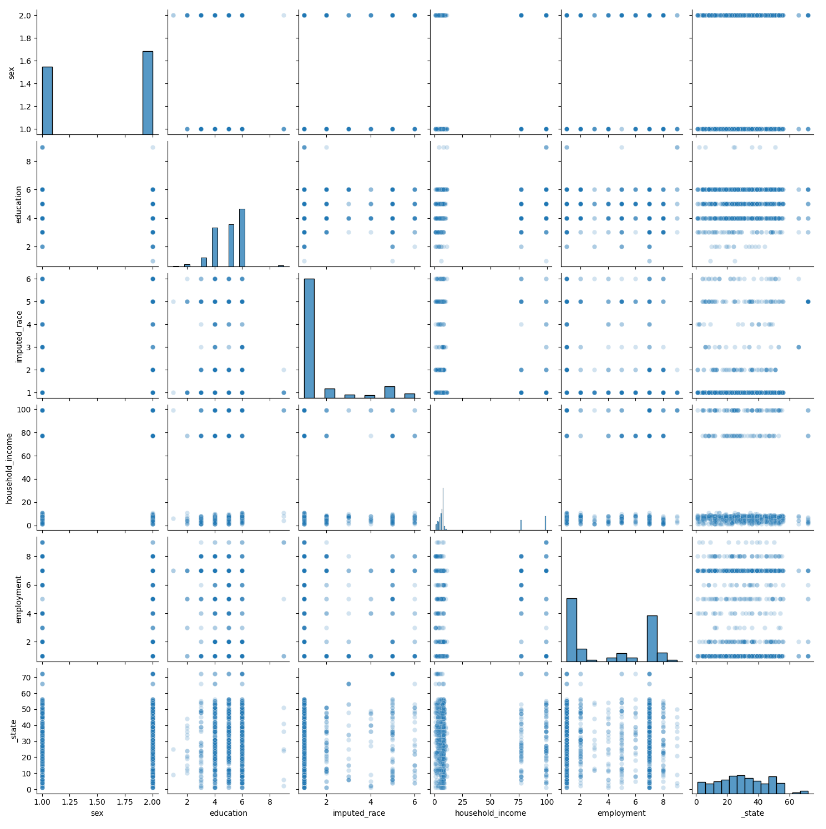

It is difficult to identify any clear correlation among predictors, which may mean each predictor is significant enough to be considered.

One potential issue involves treating categorical values as ordinal (for instance, treating race as ordered integers), so we'll have to be cautious about identifying any linear relationships and potentially readjust our predictor values as well.

### Correlation Matrix

See milestone 3 for accompanying code. 

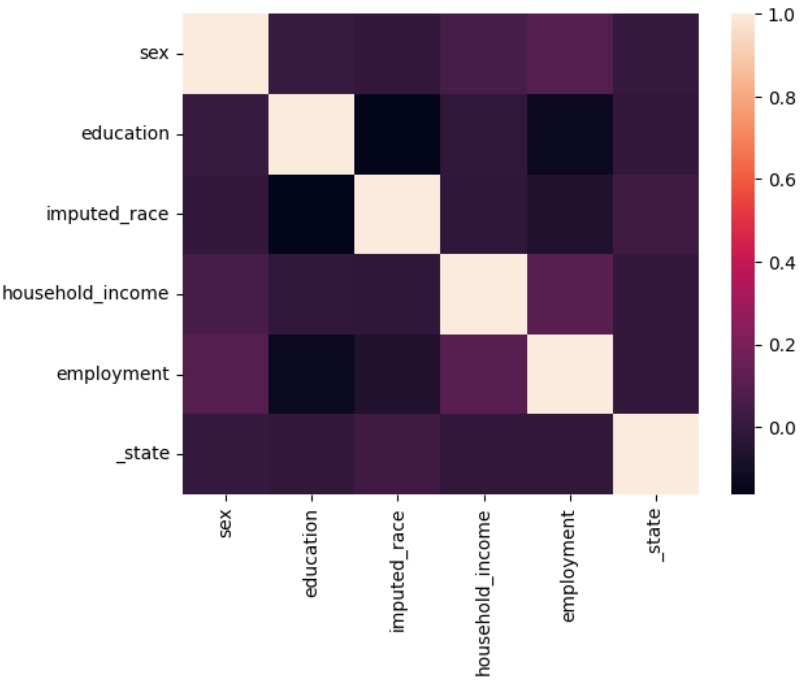

We confirm here that our primary variables have very little correlation, so our models should avoid collinearity using these predictors.

We can also confirm here that our subpredictors are correlateed with our primary predictors:

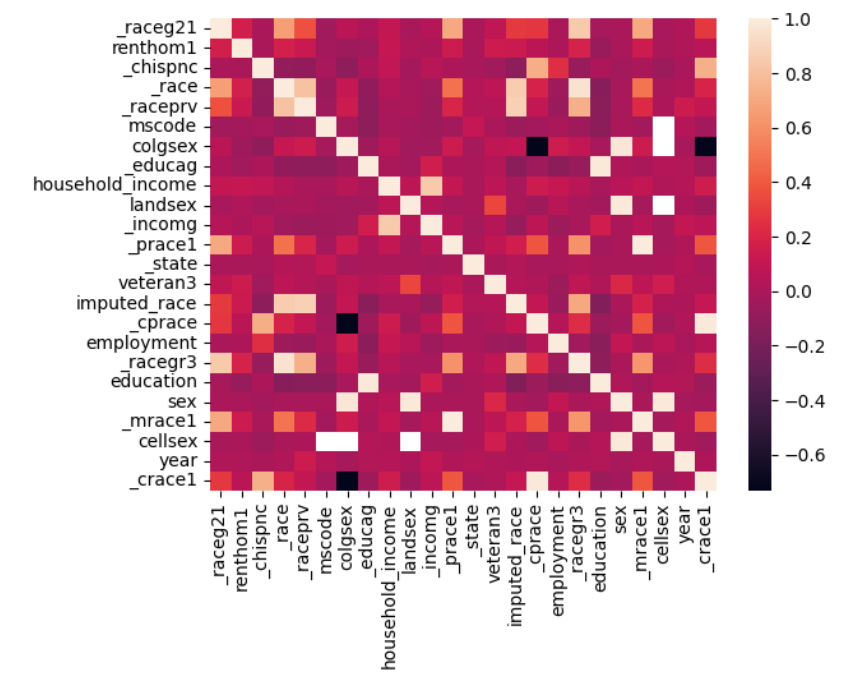

For instance, education is correlation with _educag (a subpredictor of education), race predictors are often correlated (i.e. _crace1 and _cprace), and sex predictors are correlated too (i.e. colgsex, a subpredictor of sex).

### Variables of Interest

After checking for missingness and visualizing predictor / response relationships (see Milestone 3), we determined that the following were our primary predictors:

In [7]:
primary_predictors = ["sex", "education", "imputed_race", "household_income", "employment", "_state", "menthlth"]

### Notes on Data Imbalances and Resampling

We see that there are certain absolute and/or simple majorities present in each explored variable of interest. Females are the absolute majority sex, college graduates are the simple majority education level, and whites (non-Hispanics) are the absolute majority imputed race. While it is possible to resample the data and create a balanced dataset, we decided not to resample the data at this time in order to maintain the representativeness and interpretability of the dataset.

For example, there is a slightly larger percentage of females than males in the USA and the US Census Bureau estimated that the USA was ~75% white in 2022 which aligns with the percentages on our graphs. The aim is to reflect real-world demographics and ensure that our findings are applicable to broader populations. By not artificially balancing the data, we preserve the natural variations in demographic factors. We will instead address these imbalances by ensuring that each class is adequately represented in both training and testing sets.

The line graphs depicting percentages of sex, education, and imputed race variables of interest consistently show similar patterns over the five-year period, appearing as horizontal lines for each response. The stability in these percentages raises questions about potential data calculation errors or variations in data collection methods. Given the relatively short timeframe and minimal reported changes in data collection processes, it is possible that these findings reflect the consistent nature of these demographic attributes throughout the five-year span. This is something we will further analyze in future work.

<a id="p4"></a>
    
# Modeling

[Return to contents](#contents)

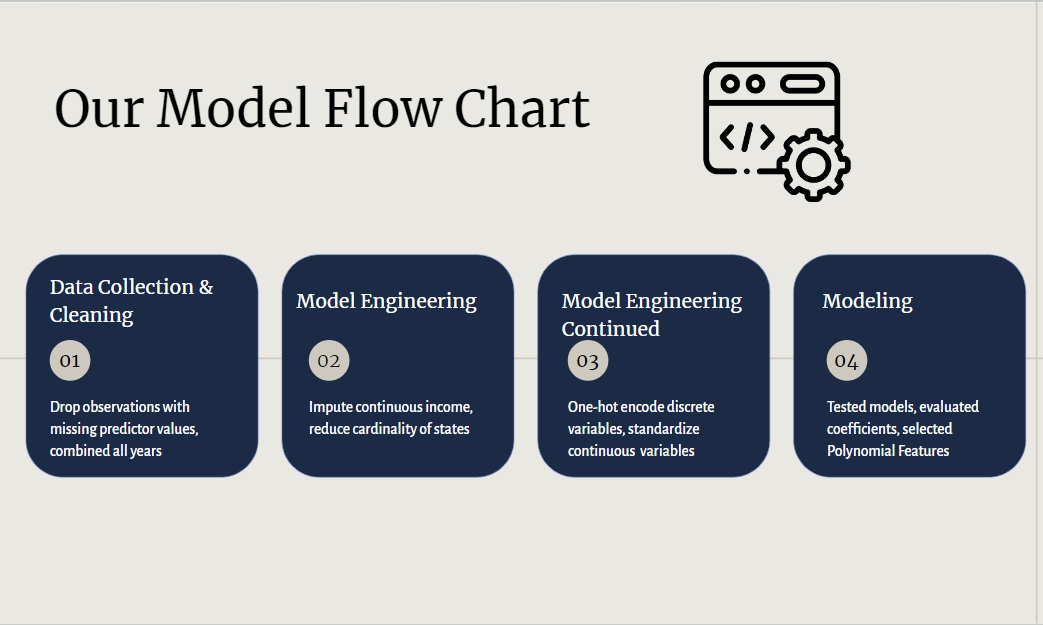

<a id="p4s1"></a>

## Baseline Model

[Return to contents](#contents)


### Split Data and Train Basic Linear Regression Functions



Here, we define functions to split our data and create a Linear Regression as our baseline model.

In [8]:
def split_data(final_df):
    variables = ["sex", "education", "imputed_race", "household_income", "employment", "_state", "menthlth"]
    
    print(f'{len(final_df[variables]) - len(final_df[variables].dropna())} entries with missing data')
    
    data_train, data_test = train_test_split(
        final_df[variables].dropna(),
        test_size=0.2,
        random_state=121,
        shuffle=True
    )
    
    X_train, y_train = data_train.drop(columns=["menthlth"]), data_train["menthlth"] 
    X_test, y_test = data_test.drop(columns=["menthlth"]), data_test["menthlth"]
    
    return X_train, X_test, y_train, y_test

In [9]:
def train_basic_linear(X_train, X_test, y_train, y_test):
    predictors = ["sex", "education", "imputed_race", "household_income", "employment", "_state"]
    
    lin_reg = LinearRegression().fit(X_train[predictors], y_train)
    
    acc_train_lin_reg = lin_reg.score(X_train[predictors], y_train)
    acc_test_lin_reg = lin_reg.score(X_test[predictors], y_test)
    
    # Grab model's intercept and coefs regardless of their shape
    # (which depends on how x and y were shaped)
    lin_reg_intercept = np.array(lin_reg.intercept_).flatten()[0]
    lin_reg_coefs = lin_reg.coef_.flatten()
    
    print(
        "The intercept and coefficients for the 'baseline Linear Regression' model are:"
        "\n\n\t{:<20}{:.4f}".format(
            "intercept", lin_reg_intercept
        )
    )
    for predictor, coef in zip(predictors, lin_reg_coefs):
        print("\t{:<20}{:.4f}".format(predictor, coef))
    
    print(
        "\nThe classification accuracies for 'baseline Linear Regression' are:"
        "\n\n\tTrain\t{:.4f}\n\tTEST\t{:.4f}"
        .format(acc_train_lin_reg, acc_test_lin_reg)
    )

    return lin_reg

### Clean Data and Test Baseline Linear Regression Model

Here, we use the functions above (in a similar sequence to the pipeline below) to clean our data and test a linear regression model. We start to gauge how effective a Linear Regression may be in terms of best describing our dataset.

In [10]:
renamed_dfs = restructure_data()
cleaned_dfs = concatenate_data(renamed_dfs)
cleaned_dfs.head()

Year 2017 data loaded!
Year 2018 data loaded!
Year 2019 data loaded!
Year 2020 data loaded!
Year 2021 data loaded!


,_racegr3,_raceg21,_state,cellsex,_crace1,employment,veteran3,_chispnc,household_income,_cprace,...,_race,_raceprv,year,landsex,_incomg,_mrace1,education,_prace1,colgsex,imputed_race
0,1.0,1.0,1,NaN,NaN,7.0,1.0,NaN,6.0,NaN,...,1.0,1.0,2017,NaN,4,1.0,6.0,1.0,NaN,1
1,1.0,1.0,1,NaN,NaN,7.0,2.0,NaN,8.0,NaN,...,1.0,1.0,2017,NaN,5,1.0,6.0,1.0,NaN,1
2,1.0,1.0,1,NaN,NaN,7.0,2.0,NaN,99.0,NaN,...,1.0,1.0,2017,NaN,9,1.0,2.0,1.0,NaN,1
3,1.0,1.0,1,NaN,NaN,7.0,2.0,NaN,1.0,NaN,...,1.0,1.0,2017,NaN,1,1.0,3.0,1.0,NaN,1
4,1.0,1.0,1,NaN,NaN,8.0,2.0,NaN,2.0,NaN,...,1.0,1.0,2017,NaN,1,1.0,2.0,1.0,NaN,1


In [11]:
final_df = remove_missingness(cleaned_dfs)
final_df.head()

,_racegr3,_raceg21,_state,cellsex,_crace1,employment,veteran3,_chispnc,household_income,_cprace,...,_race,_raceprv,year,landsex,_incomg,_mrace1,education,_prace1,colgsex,imputed_race
0,1.0,1.0,1,NaN,NaN,7.0,1.0,NaN,6.0,NaN,...,1.0,1.0,2017,NaN,4.0,1.0,6.0,1.0,NaN,1
1,1.0,1.0,1,NaN,NaN,7.0,2.0,NaN,8.0,NaN,...,1.0,1.0,2017,NaN,5.0,1.0,6.0,1.0,NaN,1
2,1.0,1.0,1,NaN,NaN,7.0,2.0,NaN,NaN,NaN,...,1.0,1.0,2017,NaN,NaN,1.0,2.0,1.0,NaN,1
3,1.0,1.0,1,NaN,NaN,7.0,2.0,NaN,1.0,NaN,...,1.0,1.0,2017,NaN,1.0,1.0,3.0,1.0,NaN,1
4,1.0,1.0,1,NaN,NaN,8.0,2.0,NaN,2.0,NaN,...,1.0,1.0,2017,NaN,1.0,1.0,2.0,1.0,NaN,1


In [12]:
X_train, X_test, y_train, y_test = split_data(final_df)

440770 entries with missing data


We recognize that this is a substantial number of rows with missing data. Currently, we drop each of those rows in our split_data function to produce a linear regression. Though there are still well over 1.74 million usable rows in the dataset, we believe it would be better to impute many of those values instead. Robert, we'd love to meet with you to discuss what an appropriate imputation method would be!

### Confirming Linear Regression as Baseline Model

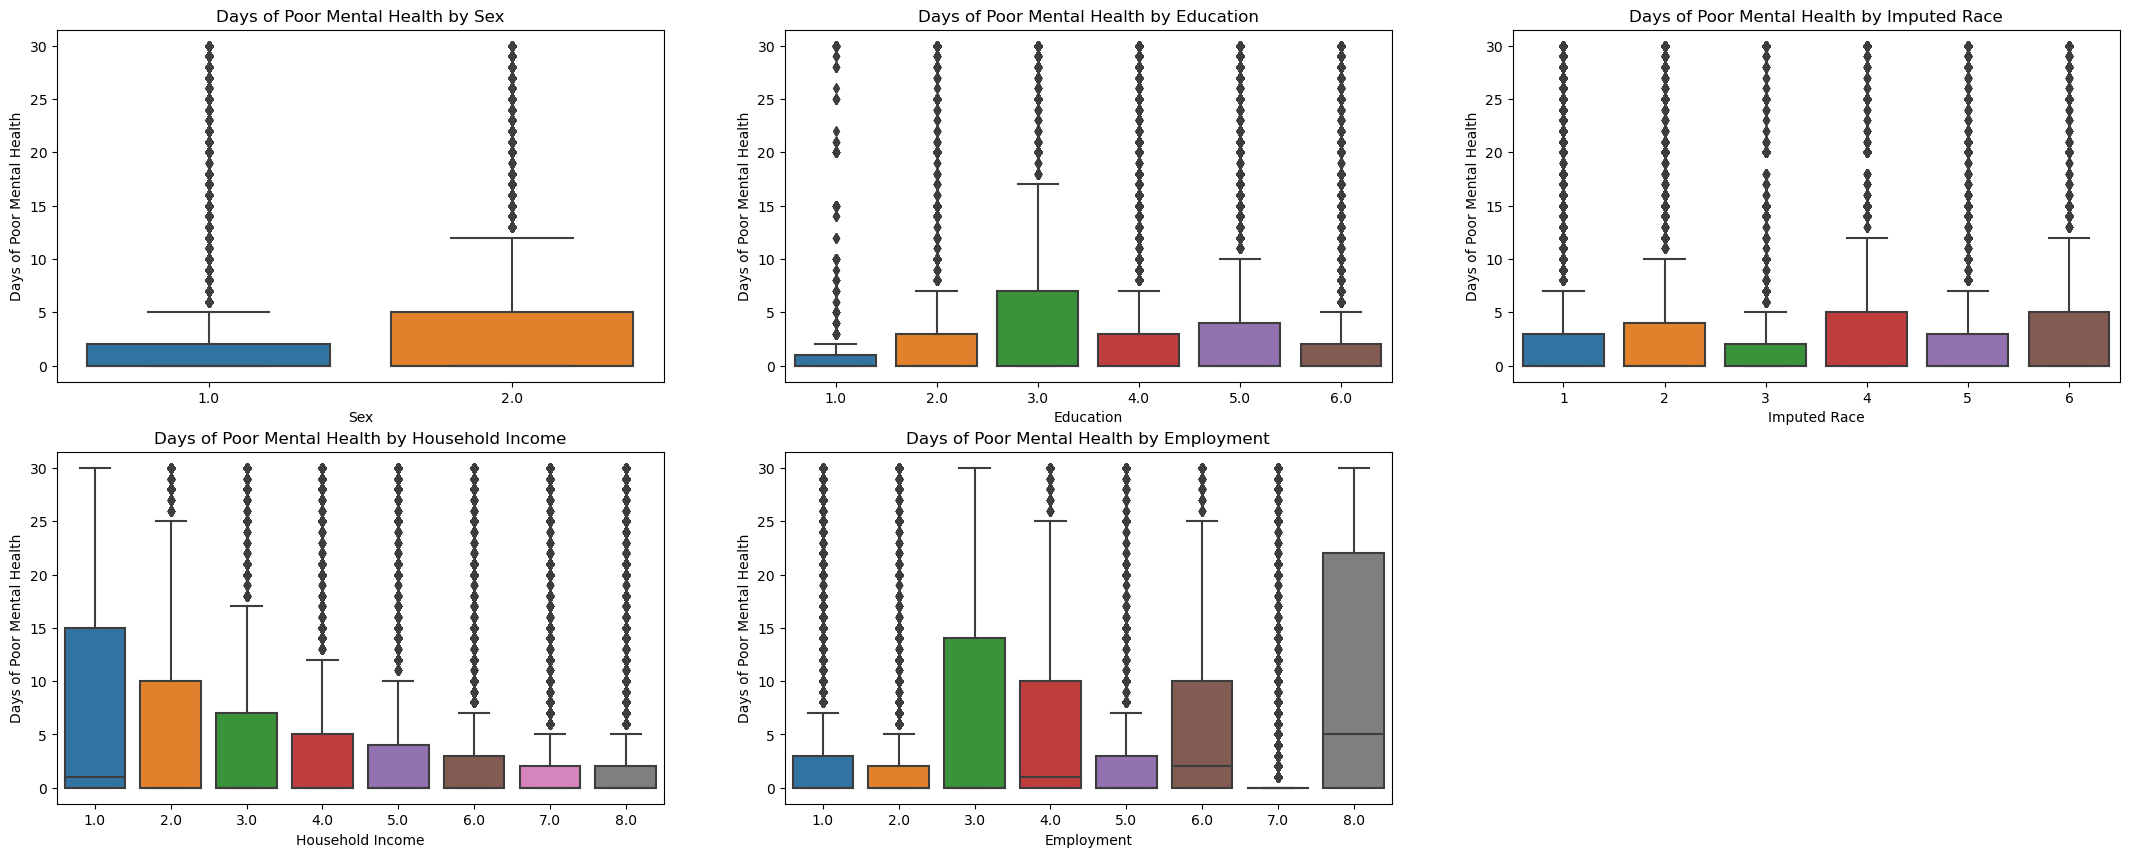

In [13]:
# Visualizations of relationship between predictors and response using boxplots
# Create box plots between each continuous predictor and 'admitted'

cat_predictors = X_train.columns[:-1]

for i in range(len(cat_predictors)):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x = X_train[cat_predictors[i]], y = y_train).set(xlabel = cat_predictors[i].title().replace("_", " "), ylabel = 'Days of Poor Mental Health', title = f'Days of Poor Mental Health by {cat_predictors[i].title().replace("_", " ")}')

plt.subplots_adjust(right = 1.5, top = 1.4)

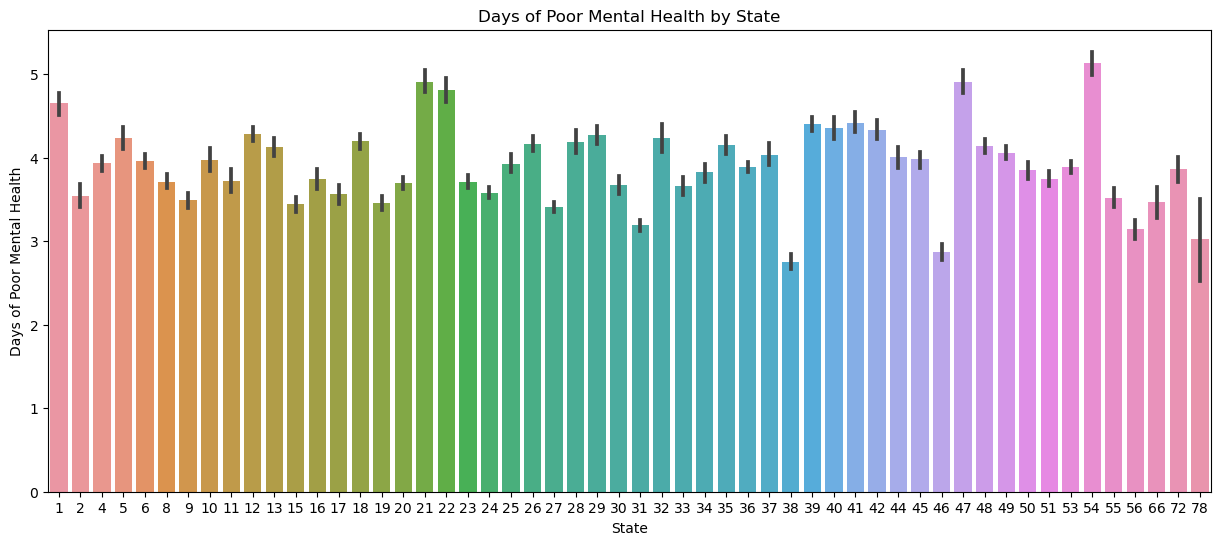

In [14]:
sns.barplot(x = X_train['_state'], y = y_train).set(xlabel = "State", ylabel = "Days of Poor Mental Health", title = 'Days of Poor Mental Health by State');

#### Analysis on Variables of Interest

As can be seen in these plots above each of our predictors have a clear relationship to 'menthlth,' or in other words, the number of days of poor mental experienced by a respondent within the past 30 days.


- **Sex**: It can be seen that those with a value of 2 for the sex variable, ie. respondents assigned female at birth, have a median of around 13 days with poor mental health, which is over double the amount for those with a value of 1 for the sex variable, or those assigned male at birth.


- **Education**: Those individuals with values of 3, Grades 9 through 11 (Some high school), and 5, College 1 year to 3 years (Some college or
technical school), had the highest and second highest median number of days with poor mental health. This makes sense, as those years encapsulate times of great transition from lower levels of schooling to new, higher levels of schooling. Values of 4, Grade 12 or GED (High school graduate), or 6, College 4 years or more (College graduate), have vastly lower median numbers of poor mental days. It may be that high schoolers and undergraduates are working hard and accumulating stress over the course of their freshman to junior years of school before finally being able to relax upon college admission/confirmation of postgraduate plans. As for 1, Never attended school or only kindergarten, there are few observations in this category and it is likely that the researchers and parent respondents were unable to accurately poll their young children for mental health (and the children may not be equipped to count beyond 10). Funnily enough the last category, those with a value of 2, or Grades 1 through 8 (Elementary), have a similar median number of poor mental health days as those with values of 4 and 6. 


- **Race (Imputed)**: Compared to the majority white population (those with a value of 1), Black Americans (2), Asian Americans (4), and Other race Non-Hispanics (6) have higher median numbers of poor mental health days. The remaining categories, American Indians/Alaskan Natives (3), and Native Hawaiian or other Pacific Islander Americans (5), have around the same or lower median numbers of poor mental health days, though it is important to note that they have much lower response rates and it is likely that the effects of the non-response bias within these populations may be stronger than it others. In a report titled "No Connection: The Issue of Internet on the Reservation," the researchers write that "Only 68% of
those living on rural reservations have telephone service," (Donnellan 2017:351). In this case, it is likely only the most wealthy among these populations that are able to respond to the BRFSS. Wealth is a very important predictor of mental health, as will be explained below.


- **Household Income**: There is a strong negative relationship between one's household income and the number of poor mental health days they report experiencing within the thirty days prior to interview. From values of 1, Less than $10,000, to values of 8, $75,000 or more, the median number of poor mental health days experienced declines from around 30 days to aruond 5. There is a clear correlation between improvements in mental health and household income.


- **Employment**: Out of the 8 categories, 3, Out of work for 1 year or more, 4, Out of work for less than 1 year, 6, Student, and 8, Unable to Work, have the highest median number of poor mental health days. In descending order are those Unable to Work, those Out of Work for 1 year or more, Students, and finally Those Out of work for less than 1 year. As can be seen here, unemployment is correlated with poorer mental health. 


- **State**: Out of the 50 states and 4 territories (including Washington, D.C.), the states with the highest median number of poor mental health days are in descending order: West Virginia (54), Tennesee (47), Kentucky (21), Louisiana (22), and Alabama (01). These states are primarily in the Southeastern United States and are among the bottom 10 states in terms of median household income according to the [World Population Review](https://worldpopulationreview.com/state-rankings/median-household-income-by-state). As we have seen above that household income is strongly correlated with median number of poor mental health days it is no wonder then that states with lower median incomes also have higher median numbers of days with poor mental health.

In [15]:
lin_reg = train_basic_linear(X_train, X_test, y_train, y_test)

The intercept and coefficients for the 'baseline Linear Regression' model are:

	intercept           6.8291
	sex                 1.0799
	education           -0.0426
	imputed_race        -0.0146
	household_income    -0.7000
	employment          -0.0178
	_state              -0.0023

The classification accuracies for 'baseline Linear Regression' are:

	Train	0.0398
	TEST	0.0385


Here is an example of how our linear regression performs on one predictor, household_income. Once we fix the numbering of our variables, we'll be able to properly train on more than one predictor. 

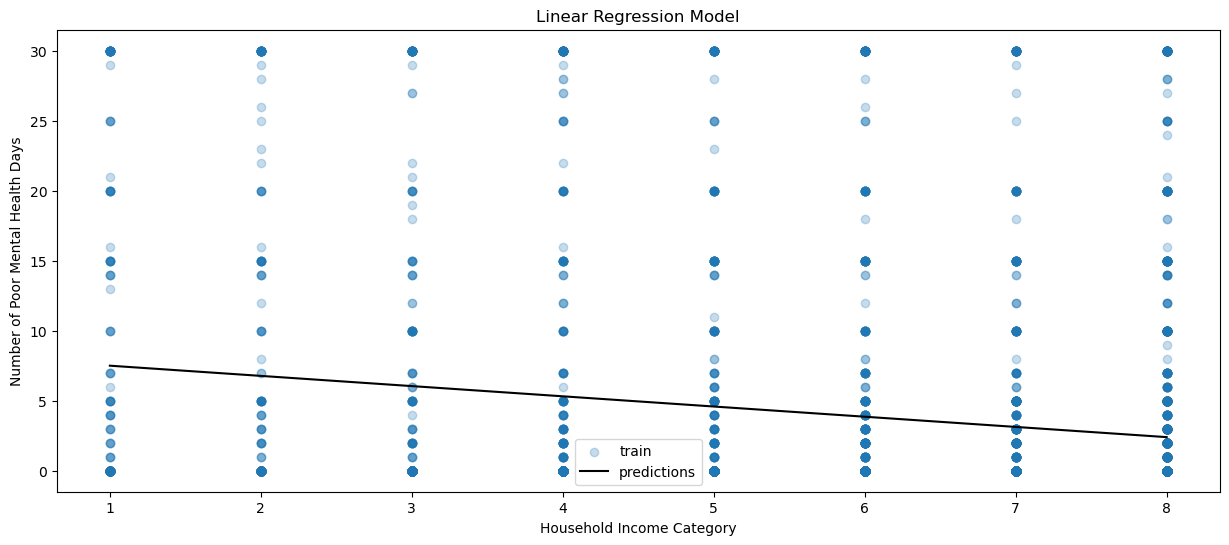

In [16]:
# Visualize Linear Regression over each year
X_temp = X_train.head(5000)
y_temp = y_train.head(5000)
lin_reg2 = LinearRegression().fit(pd.DataFrame(X_temp["household_income"]), y_temp)
x_lin = np.linspace(pd.DataFrame(X_temp["household_income"]).min(), pd.DataFrame(X_temp["household_income"]).max(), 1000)
y_pred = lin_reg2.predict(x_lin)
plt.scatter(X_temp["household_income"], pd.DataFrame(y_temp), alpha=0.25, label='train')
plt.plot(x_lin, y_pred, c='k', label='predictions');
plt.xlabel('Household Income Category')
plt.ylabel('Number of Poor Mental Health Days')
plt.title('Linear Regression Model')
plt.legend();

### Interpreting Baseline Linear Regression Results

Other than the variables with arbitrary ordering that we'll account for in the future, these intercepts largely make sense. It seems that rising houshold income is associated with a decline in poor mental health days, as is gaining education or employment. Logically, these make sense, because they place people in a position of better financial and emotional security, likely leading to better mental health outcomes. It seems that a linear model does make sense, though we'll have to investigate further (especially to see if there is a need for polynomial features), especially once we fix the numbering of variables.

Note that our classification accuracies are very low here, but that is to be expected: given that our response variable has 30 possible values, and the difference between, say, 29 and 30 days of poor mental health is largely trivial, we're more interested in seeing if our model predicts a value *close* to the actual number of days. 

The linear regression visualization above also supports that a linear regression may be reasonable - generally, there is a higher concentration of data points in the lower right corner than the lower left corner, meaning people with higher incomes to seem to have fewer poor mental health days. 

For our final steps, we'll adjust our predictor numbering, fine-tune our linear regression model (and train additional models as necessary), and potentially investigate these trends relative to our year variable as well. 

### Baseline Pipeline

Below is a function representing the full pipeline of our model as currently designed. 

In [17]:
def pipeline():

    # Load data and handle discrepancies between years
    renamed_dfs = restructure_data()

    # Concatenate all years into one dataframe
    cleaned_dfs = concatenate_data(renamed_dfs)

    # Handle missing values that are not blank
    final_df = remove_missingness(cleaned_dfs)

    # Handle missingness and split data
    X_train, X_test, y_train, y_test = split_data(final_df)

    # Train a linear regression model and print intercepts
    lin_reg = train_linear(X_train, X_test, y_train, y_test)

    return lin_reg
    

<a id="p4s2"></a>

## Model Engineering/Processing

[Return to contents](#contents)

### Simulating continuous data from discrete income brackets

Described in [data handling](#p3s1).

In [18]:
ref_income = pd.read_csv(f"data/2019_hinc6_cleaned.csv")
ref_income.columns = ['total_household_income', 'frequency', 'mean_income_dollars', 'standard_error_dollars']

income_strings = ref_income["mean_income_dollars"].tolist()
mean_incomes = [int(income.replace(',', '')) for income in income_strings]

frequency_strings = ref_income["frequency"].tolist()
frequencies = [int(frequency.replace(',', '')) for frequency in frequency_strings]

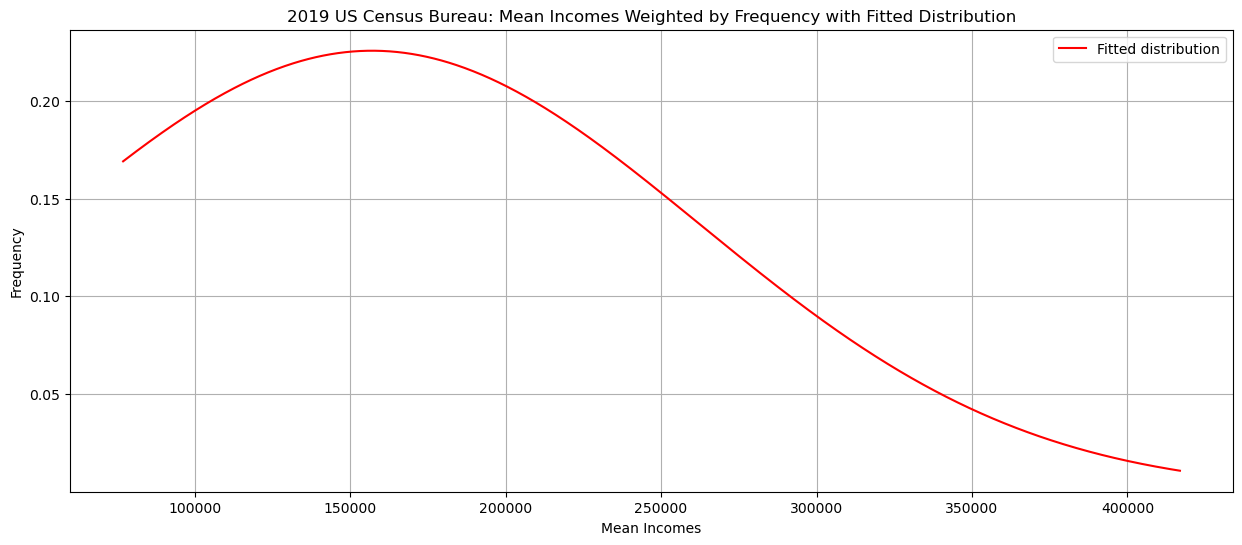

In [19]:
#Convert data into individual observations with frequencies
income_integers = np.repeat(mean_incomes, frequencies)

#Fit distribution to the mean incomes with frequencies as weights
def neg_log_likelihood(params):
    loc, scale = params
    total_log_likelihood = 0
    for mean_income, frequency in zip(mean_incomes, frequencies):
        log_likelihood = -np.sum(stats.norm.logpdf(np.repeat(mean_income, frequency), loc=loc, scale=scale))
        total_log_likelihood += log_likelihood
    return total_log_likelihood

result = minimize(neg_log_likelihood, x0=(np.mean(mean_incomes), np.std(mean_incomes)))
loc, scale = result.x

#Plot fitted distribution
x_values = np.linspace(min(income_integers), max(income_integers), 1000)
fitted_distribution = stats.norm(loc=loc, scale=scale)
plt.plot(x_values, fitted_distribution.pdf(x_values) * sum(frequencies), 'r-', label='Fitted distribution')

plt.xlabel('Mean Incomes')
plt.ylabel('Frequency')
plt.title('2019 US Census Bureau: Mean Incomes Weighted by Frequency with Fitted Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
def income_convert(label):
    if label in [1.0, 5.0]:
        interval = 10000
        income = np.random.uniform((label - 1) * interval, label * interval - 1)
        income = np.round(income, 2)
    elif label in [2.0, 3.0, 4.0]: 
        interval = 5000
        income = np.random.uniform((label - 1) * interval, label * interval - 1)
        income = np.round(income, 2)
    elif label == 6.0: 
        interval = 15000
        income = np.random.uniform((label - 1) * interval, label * interval - 1)
        income = np.round(income, 2)
    elif label == 7.0: 
        interval = 25000
        income = np.random.uniform((label - 1) * interval, label * interval - 1)
        income = np.round(income, 2)
    elif label == 8.0:
        income = max(75001, fitted_distribution.rvs(size=1)[0])  # Sample from the fitted distribution
    else:
        income = np.nan
    return income

In [21]:
#Applying income convert function 
final_df["household_income2"] = final_df["household_income"].apply(income_convert)
#Comparing original to converted data
income_check = final_df.loc[final_df["household_income"]==8.0]
income_check[["household_income", "household_income2"]]

,household_income,household_income2
1,8.0,75001.000000
6,8.0,75001.000000
31,8.0,290371.025511
37,8.0,75001.000000
41,8.0,182590.771071
...,...,...
2146341,8.0,85216.570821
2146352,8.0,289860.337350
2146359,8.0,403567.967435
2146364,8.0,75001.000000


Fraction of >75K income that are not predicted to just be $75k: 72.2153%


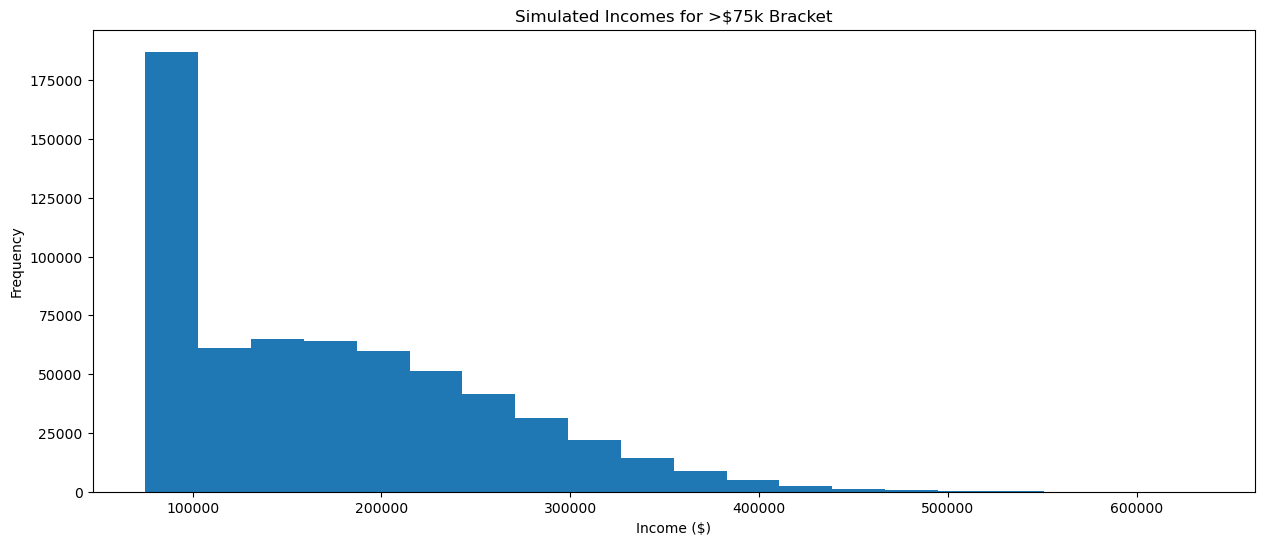

In [22]:
#Plotting simulated data for topmost bracket 
plt.hist(income_check.household_income2, bins = 20)
plt.title('Simulated Incomes for >$75k Bracket')
plt.xlabel('Income ($)')
plt.ylabel('Frequency')
plt.show;
print(f'Fraction of >75K income that are not predicted to just be $75k: {100*(len(income_check["household_income2"].value_counts())-max(income_check["household_income2"].value_counts()))/len(income_check["household_income2"].value_counts()):.4f}%')

In [23]:
#Replacing original discrete income 
final_df = final_df.drop(columns=['household_income'])
final_df = final_df.rename(columns={'household_income2': 'household_income'})

### Consolidating states

Described in [data handling](#p3s1).

#### Relabeling according to US Census Bureau divisions

In [24]:
def state_relabel(label):
    if label in [9, 23, 25, 33, 44, 50]:
        division = 1 #New England 
    elif label in [34, 36, 42]: 
        division = 2 #Mid Atlantic 
    elif label in [17, 18, 26, 39, 55]: 
        division = 3 #East North Central
    elif label in [34, 36, 42]: 
        division = 4 #West North Central
    elif label in [10, 11, 12, 13, 24, 37, 45, 51, 54]: 
        division = 5 #South Atlantic
    elif label in [1, 21, 28, 49]: 
        division = 6 #East South Central
    elif label in [5, 22, 40, 48]: 
        division = 7 #West South Central
    elif label in [4, 8, 16, 30, 32, 35, 49, 56]: 
        division = 8 #Mountain
    elif label in [2, 6, 15, 41, 53]: 
        division = 9 #Pacific
    elif label in [66, 72, 78]: 
        division = 10 #Uncategorized by US Census Bureau (select territories)
    else:
        division = label
    return division

In [25]:
final_df["_division"] = final_df["_state"].apply(state_relabel)
final_df = final_df.drop(columns=['_state'])
final_df = final_df.rename(columns={'_division': '_state'})
final_df.head()

,_racegr3,_raceg21,cellsex,_crace1,employment,veteran3,_chispnc,_cprace,menthlth,sex,...,year,landsex,_incomg,_mrace1,education,_prace1,colgsex,imputed_race,household_income,_state
0,1.0,1.0,NaN,NaN,7.0,1.0,NaN,NaN,0.0,2.0,...,2017,NaN,4.0,1.0,6.0,1.0,NaN,1,81708.46,6
1,1.0,1.0,NaN,NaN,7.0,2.0,NaN,NaN,0.0,1.0,...,2017,NaN,5.0,1.0,6.0,1.0,NaN,1,75001.00,6
2,1.0,1.0,NaN,NaN,7.0,2.0,NaN,NaN,0.0,1.0,...,2017,NaN,NaN,1.0,2.0,1.0,NaN,1,NaN,6
3,1.0,1.0,NaN,NaN,7.0,2.0,NaN,NaN,0.0,2.0,...,2017,NaN,1.0,1.0,3.0,1.0,NaN,1,3419.20,6
4,1.0,1.0,NaN,NaN,8.0,2.0,NaN,NaN,0.0,2.0,...,2017,NaN,1.0,1.0,2.0,1.0,NaN,1,7255.90,6


#### Alternate relabeling method according to response percentage

A less effective option is to calculate the percentage of responses from each state and group the states with a response percentage below a certain threshold as a new label. This does not reduce the number of levels as effectively as the method above, meaning multicollinearity and high cardinality are still concerns with this method. We've included the code below (commented out) for reference.

In [26]:
# total = final_df["_state"].value_counts().sum()
# state_count = final_df["_state"].value_counts()
# state_percent = np.round(100*(state_count/total), 2)

# df_state_percent = state_percent.to_frame()
# df_state_percent = state_percent.reset_index()	
# df_state_percent.columns = ['_state', 'state_percent']

# #Dictionary mapping _state values to their percentages
# state_percent_dict = dict(zip(df_state_percent["_state"], df_state_percent["state_percent"]))

# #Iterate through the dictionary to find _state values with percentages < 1.00 and replace them with 73
# for state, percent in state_percent_dict.items():
#     if percent < 1.00: #percentage chosen based on p  
#         final_df.loc[final_df["_state"] == state, "_state"] = 73 

### One Hot Encoding and Scaling

We use one-hot encoding on discrete data to ensure that ordinality is not an issue when training models. Since income is now continuous, we need to standardize income rather than one-hot encoding it. MinMaxScaler was chosen over StandardScaler to match one-hot encoding in non-negative values.

In [27]:
X_train, X_test, y_train, y_test = split_data(final_df)

#Making sex binary
X_train.loc[X_train["sex"] == 2.0, "sex"] = 0
X_test.loc[X_test["sex"] == 2.0, "sex"] = 0

discrete_columns = ["sex", "education", "imputed_race", "employment", "_state"]
continuous_columns = ['household_income']  

preprocessor = ColumnTransformer(
    transformers=[
        ('discrete', OneHotEncoder(), discrete_columns),  #One-hot encode discrete columns
        ('continuous', MinMaxScaler(), continuous_columns)  #Scale the income column
    ],
    remainder='passthrough'  #Pass through columns not specified
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed = pd.DataFrame.sparse.from_spmatrix(X_train_processed)
X_test_processed = pd.DataFrame.sparse.from_spmatrix(X_test_processed)

440770 entries with missing data


<a id="p4s3"></a>

## Model Testing

[Return to contents](#contents)

We'll now train multiple different models to gauge which one performs the best. We'll test each model type on the original dataset and the processed dataset, to test whether variable processing methods are  effective. 

In [28]:
def eval_linear(X_train, X_test, y_train, y_test):
    enc_lr = LinearRegression(fit_intercept=False)
    enc_lr.fit(X_train, y_train)

    acc_train_enc_lr = enc_lr.score(X_train, y_train)
    acc_test_enc_lr = enc_lr.score(X_test, y_test)

    return acc_train_enc_lr, acc_test_enc_lr, enc_lr

In [29]:
#Applying linear regression
lr_acc = eval_linear(X_train, X_test, y_train, y_test)
onehot_lr_acc = eval_linear(X_train_processed, X_test_processed, y_train, y_test)

print(
    "\nThe r^2 score for the 'unmodified data' are:"
    "\n\n\tTrain\t{:.6f}\n\tTEST\t{:.6f}"
    .format(lr_acc[0], lr_acc[1])
)

print(
    "\nThe r^2 score for the 'one hot encoded data' are:"
    "\n\n\tTrain\t{:.6f}\n\tTEST\t{:.6f}"
    .format(onehot_lr_acc[0], onehot_lr_acc[1])
)


The r^2 score for the 'unmodified data' are:

	Train	0.005975
	TEST	0.004878

The r^2 score for the 'one hot encoded data' are:

	Train	0.084037
	TEST	0.084386


In [30]:
def eval_poly(X_train, X_test, y_train, y_test, degree):
    poly = PolynomialFeatures(degree=degree, 
                          interaction_only=False,
                          include_bias=True)

    poly_train = poly.fit_transform(X_train)

    # Compute the polynomial features in test set
    poly_test = poly.transform(X_test)

    linreg = LinearRegression(fit_intercept=True).fit(poly_train, y_train)

    acc_train = linreg.score(poly_train, y_train)
    acc_test = linreg.score(poly_test, y_test)

    return acc_train, acc_test

In [31]:
#Note: "if i == 2" is included since degree 3 is computationally infeasible. 

for i in range(2,4):

    print("Degree " + str(i))
    
    poly_acc = eval_poly(X_train, X_test, y_train, y_test, i)

    print(
        "\nThe r^2 score for the 'unmodified data' are:"
        "\n\n\tTrain\t{:.6f}\n\tTEST\t{:.6f}"
        .format(poly_acc[0], poly_acc[1])
    )

    if i == 2:
        onehot_poly_acc = eval_poly(X_train_processed, X_test_processed, y_train, y_test, i)
    
        print(
            "\nThe r^2 score for the 'one hot encoded data' are:"
            "\n\n\tTrain\t{:.6f}\n\tTEST\t{:.6f}"
            .format(onehot_poly_acc[0], onehot_poly_acc[1])
        )


Degree 2

The r^2 score for the 'unmodified data' are:

	Train	0.041222
	TEST	0.040654

The r^2 score for the 'one hot encoded data' are:

	Train	0.092458
	TEST	0.092487
Degree 3

The r^2 score for the 'unmodified data' are:

	Train	-0.006251
	TEST	-0.008497


Here, it appears that a polynomial degree of 2 is more accurate than a linear regression, both for one-hot-encoded data and the original dataset. 

While a degree of 3 works well for unmodified data, it appears to overfit the one-hot-encoded data. 

Using a Polynomial Features model makes more sense than a linear regression, since there are interaction terms incorporated into the model. We'd expect some degree of interaction between our predictors - for instance, income typically correlates with sex and race - so accommodating those additional features seems to make our model more accurate. 

In [32]:
def eval_dtree(X_train, X_test, y_train, y_test, max_depth):

    dtree = DecisionTreeRegressor(max_depth=max_depth).fit(X_train, y_train)

    scores = cross_val_score(estimator=dtree, X=X_train, y=y_train, cv=5, n_jobs=-1)

    cv_score = scores.mean()

    acc_train = dtree.score(X_train, y_train)
    acc_test = dtree.score(X_test, y_test)

    return acc_train, acc_test, cv_score

In [33]:
# Unmodified Data
cv_scores = []
results = []

for max_depth in range(1,16):
    result = eval_dtree(X_train, X_test, y_train, y_test, max_depth)
    cv_scores.append(result[2])
    results.append(result)

best_depth = cv_scores.index(max(cv_scores)) + 1

print("Best Depth Unmodified: " + str(best_depth))

print(
    "\nThe r^2 score for the 'unmodified data' are:"
    "\n\n\tTrain\t{:.6f}\n\tTEST\t{:.6f}"
    .format(results[best_depth - 1][0], results[best_depth - 1][1])
)

# One Hot Encoded Data
cv_scores = []
results = []

for max_depth in range(1,16):
    result = eval_dtree(X_train_processed, X_test_processed, y_train, y_test, max_depth)
    cv_scores.append(result[2])
    results.append(result)

best_depth = cv_scores.index(max(cv_scores)) + 1

print("Best Depth One Hot Encoded: " + str(best_depth))

print(
    "\nThe r^2 for the 'one hot encoded data' are:"
    "\n\n\tTrain\t{:.6f}\n\tTEST\t{:.6f}"
    .format(results[best_depth - 1][0], results[best_depth - 1][1])
)
    

Best Depth Unmodified: 9

The r^2 score for the 'unmodified data' are:

	Train	0.094510
	TEST	0.090333
Best Depth One Hot Encoded: 8

The r^2 for the 'one hot encoded data' are:

	Train	0.091666
	TEST	0.089266


The decision tree model produces a significant increase in accuracies for the unmodified data, but the one-hot-encoded data is still outperformed by the 2-degree Polynomial Features model. 

In [34]:
def eval_bagging(X_train, X_test, y_train, y_test, max_depth):
    bagged_model = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=max_depth), n_estimators=15, max_samples=.8)
                        
    # Fit the model on the train data
    bagged_model.fit(X_train, y_train)

    acc_train = bagged_model.score(X_train, y_train)
    acc_test = bagged_model.score(X_test, y_test)

    return acc_train, acc_test

In [35]:
bagging_acc = eval_bagging(X_train, X_test, y_train, y_test, 9)

print(
    "\nThe r^2 score for the 'unmodified data' are:"
    "\n\n\tTrain\t{:.6f}\n\tTEST\t{:.6f}"
    .format(bagging_acc[0], bagging_acc[1])
)

onehot_bagging_acc = eval_bagging(X_train_processed, X_test_processed, y_train, y_test, 10)

print(
    "\nThe r^2 score for the 'one hot encoded data' are:"
    "\n\n\tTrain\t{:.6f}\n\tTEST\t{:.6f}"
    .format(onehot_bagging_acc[0], onehot_bagging_acc[1])
)


The r^2 score for the 'unmodified data' are:

	Train	0.096991
	TEST	0.092832

The r^2 score for the 'one hot encoded data' are:

	Train	0.100313
	TEST	0.092778


The bagging model improves upon the unmodified data's accuracy, but performs virtually the same as the Polynomial Degree 2 model in one hot test data. 

In [36]:
def eval_random_forest(X_train, X_test, y_train, y_test, max_depth):
    rf = RandomForestRegressor(max_depth=max_depth, n_estimators=30)

    rf.fit(X_train, y_train)

    acc_train = rf.score(X_train, y_train)
    acc_test = rf.score(X_test, y_test)

    return acc_train, acc_test

In [37]:
rf_acc = eval_random_forest(X_train, X_test, y_train, y_test, 9)

print(
    "\nThe r^2 score for the 'unmodified data' are:"
    "\n\n\tTrain\t{:.6f}\n\tTEST\t{:.6f}"
    .format(rf_acc[0], rf_acc[1])
)

onehot_rf_acc = eval_bagging(X_train_processed, X_test_processed, y_train, y_test, 10)

print(
    "\nThe r^2 score  for the 'one hot encoded data' are:"
    "\n\n\tTrain\t{:.6f}\n\tTEST\t{:.6f}"
    .format(onehot_rf_acc[0], onehot_rf_acc[1])
)


The r^2 score for the 'unmodified data' are:

	Train	0.097085
	TEST	0.092956

The r^2 score  for the 'one hot encoded data' are:

	Train	0.100218
	TEST	0.093052


In [38]:
def eval_boosting(X_train, X_test, y_train, y_test, max_depth):
    boosted_model = GradientBoostingRegressor(max_depth=max_depth, n_estimators=30, learning_rate=0.4)

    boosted_model.fit(X_train, y_train)

    acc_train = boosted_model.score(X_train, y_train)
    acc_test = boosted_model.score(X_test, y_test)

    return acc_train, acc_test

In [39]:
boosted_acc = eval_boosting(X_train, X_test, y_train, y_test, 9)

print(
    "\nThe r^2 score for the 'unmodified data' are:"
    "\n\n\tTrain\t{:.6f}\n\tTEST\t{:.6f}"
    .format(rf_acc[0], rf_acc[1])
)

onehot_boosted_acc = eval_boosting(X_train_processed, X_test_processed, y_train, y_test, 10)

print(
    "\nThe r^2 score for the 'one hot encoded data' are:"
    "\n\n\tTrain\t{:.6f}\n\tTEST\t{:.6f}"
    .format(onehot_rf_acc[0], onehot_rf_acc[1])
)


The r^2 score for the 'unmodified data' are:

	Train	0.097085
	TEST	0.092956

The r^2 score for the 'one hot encoded data' are:

	Train	0.100218
	TEST	0.093052


It appears that our best models are boosting and random forest (equally), with Polynomial Features and Bagging close behind - in this specific case. In previous testing, polynomial features has consistently had the greatest r^2 score, so perhaps there is more variance in the other models. For that reason, and for reasons of computational power and considering interaction terms, we decided to choose polynomial features as our ideal model. 

<a id="p5"></a>
    
# Results

[Return to contents](#contents)

<a id="p5s1"></a>

## Conclusions

[Return to contents](#contents)

In developing this section, we tested our polynomial model using **feature importance** to see if there were any clear trends in interaction terms, and there were not. Like in our EDA section, it seems that each predictor is sufficiently distinct. So, even though our polynomial model is most accurate, we'll use our linear regression model's coefficients to determine which features are most important when it comes to predicting poor mental health days in the US. 

In [40]:
coefs = onehot_lr_acc[2].coef_

In [41]:
encoder = OneHotEncoder()
encoder.fit_transform(X_train[["sex", "education", "imputed_race", "employment", "_state"]])
names = encoder.get_feature_names_out(["sex", "education", "imputed_race", "employment", "_state"])

In [42]:
names = np.append(names, 'household_income')

Let's rank the feature importance for our main features!

In [43]:
new_df = pd.DataFrame(coefs, index=names, columns=["coefficient"])

In [44]:
new_df = new_df.sort_values(by='coefficient')

In [45]:
new_df.head(15)

,coefficient
household_income,-4.568503
employment_7.0,-2.206631
employment_2.0,-1.365565
employment_5.0,-1.206105
employment_1.0,-0.827553
_state_46,-0.562584
_state_38,-0.363834
_state_31,-0.170941
_state_10,-0.113244
imputed_race_3,0.008566


In [46]:
new_df.tail(15)

,coefficient
education_2.0,0.749316
_state_6,0.754273
_state_47,1.004376
education_4.0,1.044436
imputed_race_1,1.102409
employment_6.0,1.314236
imputed_race_4,1.354473
education_5.0,1.381390
education_3.0,1.546790
employment_4.0,2.036339


These coefficients make sense logically, and allow us to draw several conclusions:
- Increases in household income appear to be the most important factor in reducing poor mental health days
- Retirement (employment_7.0) is also very important in terms of reducing poor mental health days
- Being unable to work (employment_8.0) appears to increase poor mental health days the most
- Being female is associated with having more poor mental health days
- Being self employed (employment_3.0) is associated with fewer poor mental health days

Therefore, to answer our problem statement, household income appears to be the most important predictor of mental health outcomes in the United States. A related predictor, employment, also has a strong association. 

<a id="p5s2"></a>

## Strengths and Limitations

[Return to contents](#contents)

Strengths of our pipeline:
- Income upper bracket modeling matches actual distributions of incomes (spike at 75,000) according to US Census Bureau
- We reduce cardinality by about 80% and we remove ordinality of categorical variables via one hot encoding
- Pipeline is interpretable and resulting coefficient values are supported by intuition and current research 

Weaknesses of our pipeline:
- We use very few predictors due to limited computation power; using more predictors would likely improve accuracy
- We don't make use of the year of each data as a predictor, which would help us track change over time
- Our analysis is limited by time and resources so we are unable to further investigate interesting results. For example, the relatively low feature importance of race contradicts domain knowledge of race's affect on mental health and well-being, which we are unable to explain from this analysis.

<a id="p5s3"></a>

## Future Works

[Return to contents](#contents)

In the future, we would love to explore interaction terms more in-depth using Polynomial Futures. It could also be relevant to include more predictors such as age and physical health predictors (substance use, cancer, etc.) to improve the accuracy of our models. Further, we would like to compare trends in data across years as well, especially since we would expect some 2019 pandemic effects to occur. This might be more present once future years of BRFSS data have been collected (i.e. through 2025).